Saved to reverse_forward_kl.pdf
Saved to reverse_forward_kl.png


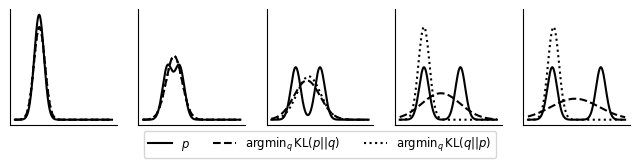

In [59]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

class GaussianMixture1D:
    def __init__(self, mixture_probs, means, stds):
        self.num_mixtures = len(mixture_probs)
        self.mixture_probs = mixture_probs
        self.means = means
        self.stds = stds

    def sample(self, num_samples=1):
        mixture_ids = np.random.choice(self.num_mixtures, size=num_samples, p=self.mixture_probs)
        result = np.zeros([num_samples])
        for sample_idx in range(num_samples):
            result[sample_idx] = np.random.normal(
                loc=self.means[mixture_ids[sample_idx]],
                scale=self.stds[mixture_ids[sample_idx]]
            )
        return result

    def logpdf(self, samples):
        mixture_logpdfs = np.zeros([len(samples), self.num_mixtures])
        for mixture_idx in range(self.num_mixtures):
            mixture_logpdfs[:, mixture_idx] = scipy.stats.norm.logpdf(
                samples,
                loc=self.means[mixture_idx],
                scale=self.stds[mixture_idx]
            )
        return sp.special.logsumexp(mixture_logpdfs + np.log(self.mixture_probs), axis=1)

    def pdf(self, samples):
        return np.exp(self.logpdf(samples))


def approx_kl(gmm_1, gmm_2, xs):
    ys = gmm_1.pdf(xs) * (gmm_1.logpdf(xs) - gmm_2.logpdf(xs))
    return np.trapz(ys, xs)


def minimize_pq(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(p, q, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def minimize_qp(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(q, p, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best
    
def main():
    p_second_means_min = 0
    p_second_means_max = 10
    num_p_second_means = 5
    p_second_mean_list = np.linspace(p_second_means_min, p_second_means_max, num_p_second_means)

    p = [None] * num_p_second_means
    q_best_forward = [None] * num_p_second_means
    kl_best_forward = [None] * num_p_second_means
    q_best_reverse = [None] * num_p_second_means
    kl_best_reverse = [None] * num_p_second_means

    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        p_mixture_probs = np.array([0.5, 0.5])
        p_means = np.array([0, p_second_mean])
        p_stds = np.array([1, 1])
        p[p_second_mean_idx] = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

        q_means_min = np.min(p_means) - 1
        q_means_max = np.max(p_means) + 1
        num_q_means = 20
        q_means = np.linspace(q_means_min, q_means_max, num_q_means)

        q_stds_min = 0.1
        q_stds_max = 5
        num_q_stds = 20
        q_stds = np.linspace(q_stds_min, q_stds_max, num_q_stds)

        trapz_xs_min = np.min(np.append(p_means, q_means_min)) - 3 * np.max(np.append(p_stds, q_stds_max))
        trapz_xs_max = np.max(np.append(p_means, q_means_min)) + 3 * np.max(np.append(p_stds, q_stds_max))
        num_trapz_points = 1000
        trapz_xs = np.linspace(trapz_xs_min, trapz_xs_max, num_trapz_points)

        q_best_forward[p_second_mean_idx], kl_best_forward[p_second_mean_idx] = minimize_pq(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )
        q_best_reverse[p_second_mean_idx], kl_best_reverse[p_second_mean_idx] = minimize_qp(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )

    # plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_p_second_means, sharex=True, sharey=True)
    fig.set_size_inches(8, 1.5)
    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        xs_min = -5
        xs_max = 15
        num_plot_points = 1000
        xs = np.linspace(xs_min, xs_max, num_plot_points)
        axs[p_second_mean_idx].plot(xs, p[p_second_mean_idx].pdf(xs), label='$p$', color='black')
        axs[p_second_mean_idx].plot(xs, q_best_forward[p_second_mean_idx].pdf(xs), 
                                    label='$\mathrm{argmin}_q \,\mathrm{KL}(p || q)$', 
                                    color='black', 
                                    linestyle='dashed')
        axs[p_second_mean_idx].plot(xs, q_best_reverse[p_second_mean_idx].pdf(xs), 
                                    label='$\mathrm{argmin}_q \,\mathrm{KL}(q || p)$', 
                                    color='black', 
                                    linestyle='dotted')

        axs[p_second_mean_idx].spines['right'].set_visible(False)
        axs[p_second_mean_idx].spines['top'].set_visible(False)
        axs[p_second_mean_idx].set_yticks([])
        axs[p_second_mean_idx].set_xticks([])

    axs[2].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize='small')
    filenames = ['reverse_forward_kl.pdf', 'reverse_forward_kl.png']
    for filename in filenames:
        fig.savefig(filename, bbox_inches='tight', dpi=200)
        print('Saved to {}'.format(filename))


if __name__ == '__main__':
    main()

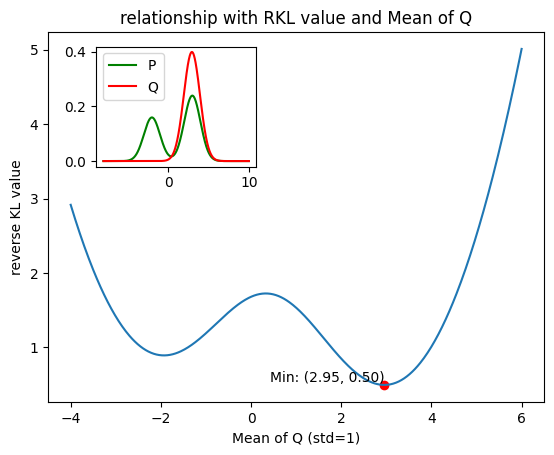

In [78]:
p_mixture_probs = np.array([0.4, 0.6])
p_means = np.array([-2, 3])
p_stds = np.array([1, 1])
p = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

xs_min = -8
xs_max = 10
num_plot_points = 1000
xs = np.linspace(xs_min, xs_max, num_plot_points)

q_mean_range = np.linspace(-4, 6, 500)
kl = []
for m in q_mean_range:
    q = GaussianMixture1D(np.array([1]), np.array([m]), np.array([1]))
    kl.append(approx_kl(q, p, xs))
plt.plot(q_mean_range, kl)

# 找到最小值点
min_index = np.argmin(kl)
min_x = q_mean_range[min_index]
min_y = kl[min_index]

# 标记最小值点
plt.scatter(min_x, min_y, color='r', label='Min Value')
# 显示最小值坐标
plt.text(min_x, min_y, f'Min: ({min_x:.2f}, {min_y:.2f})', verticalalignment='bottom', horizontalalignment='right')

# 添加轴标签
plt.xlabel('Mean of Q (std=1)')
plt.ylabel('reverse KL value')
plt.title('relationship with RKL value and Mean of Q')


# 创建小图
left, bottom, width, height = [0.2, 0.6, 0.25, 0.25]
ax2 = plt.axes([left, bottom, width, height])
q = GaussianMixture1D(np.array([1]), np.array([2.95]), np.array([1]))

# 在小图中绘制内容
ax2.plot(xs, p.pdf(xs), 'g', label='P')
ax2.plot(xs, q.pdf(xs), 'r', label='Q')
# ax2.set_title('Probability Density')

# 显示图形
plt.legend()
plt.show()

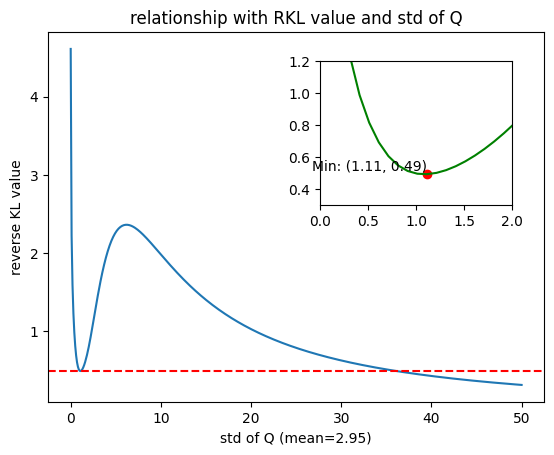

In [79]:
p_mixture_probs = np.array([0.4, 0.6])
p_means = np.array([-2, 3])
p_stds = np.array([1, 1])
p = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

xs_min = -8
xs_max = 10
num_plot_points = 1000
xs = np.linspace(xs_min, xs_max, num_plot_points)

q_std_range = np.linspace(0.01, 50, 500)
kl = []
for d in q_std_range:
    q = GaussianMixture1D(np.array([1]), np.array([2.95]), np.array([d]))
    kl.append(approx_kl(q, p, xs))
plt.plot(q_std_range, kl)

# 添加轴标签
plt.xlabel('std of Q (mean=2.95)')
plt.ylabel('reverse KL value')
plt.title('relationship with RKL value and std of Q')
plt.axhline(y=0.49, color='r', linestyle='--')

# 创建小图
left, bottom, width, height = [0.55, 0.52, 0.3, 0.3]
ax2 = plt.axes([left, bottom, width, height])

# 在小图中绘制内容
ax2.plot(q_std_range, kl, 'g')
# ax2.set_title('Zoomed In')

# 设置小图的显示范围
ax2.set_xlim(0, 2)
ax2.set_ylim(0.3, 1.2)

# 找到最小值点
min_index = np.argmin(kl[:100])
min_x = q_std_range[:100][min_index]
min_y = kl[:100][min_index]

# 标记最小值点
ax2.scatter(min_x, min_y, color='r')
# 显示最小值坐标
ax2.text(min_x, min_y, f'Min: ({min_x:.2f}, {min_y:.2f})', verticalalignment='bottom', horizontalalignment='right')


# 显示图形
# plt.legend()
plt.show()

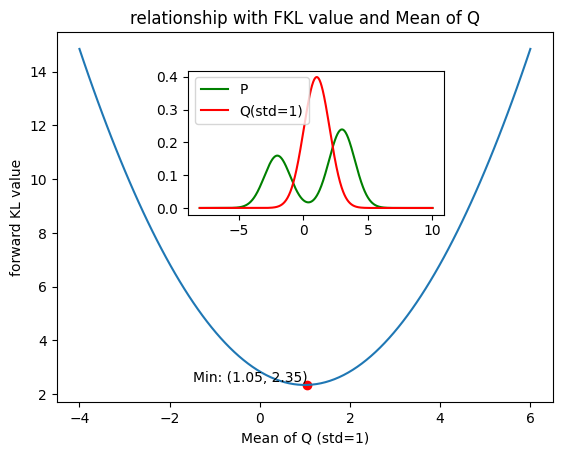

In [94]:
p_mixture_probs = np.array([0.4, 0.6])
p_means = np.array([-2, 3])
p_stds = np.array([1, 1])
p = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

xs_min = -8
xs_max = 10
num_plot_points = 1000
xs = np.linspace(xs_min, xs_max, num_plot_points)

q_mean_range = np.linspace(-4, 6, 100)
kl = []
for m in q_mean_range:
    q = GaussianMixture1D(np.array([1]), np.array([m]), np.array([1]))
    kl.append(approx_kl(p,q, xs))
plt.plot(q_mean_range, kl)

# 找到最小值点
min_index = np.argmin(kl)
min_x = q_mean_range[min_index]
min_y = kl[min_index]

# 标记最小值点
plt.scatter(min_x, min_y, color='r', label='Min Value')
# 显示最小值坐标
plt.text(min_x, min_y, f'Min: ({min_x:.2f}, {min_y:.2f})', verticalalignment='bottom', horizontalalignment='right')

# 添加轴标签
plt.xlabel('Mean of Q (std=1)')
plt.ylabel('forward KL value')
plt.title('relationship with FKL value and Mean of Q')


# 创建小图
left, bottom, width, height = [0.33, 0.5, 0.4, 0.3]
ax2 = plt.axes([left, bottom, width, height])
q = GaussianMixture1D(np.array([1]), np.array([1.05]), np.array([1]))

# 在小图中绘制内容
ax2.plot(xs, p.pdf(xs), 'g', label='P')
ax2.plot(xs, q.pdf(xs), 'r', label='Q(std=1)')
# ax2.set_title('Probability Density')

# 显示图形
plt.legend()
plt.show()

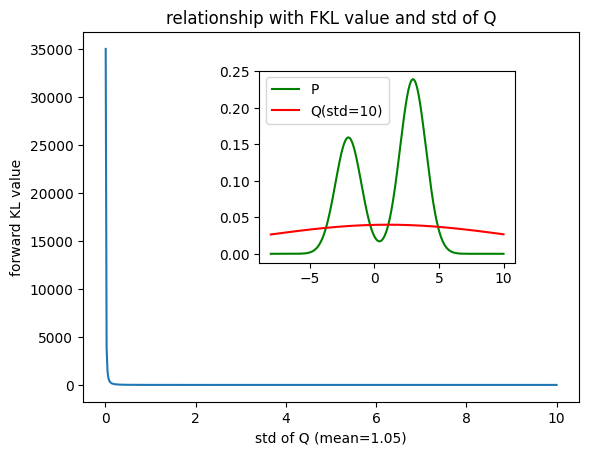

In [89]:
p_mixture_probs = np.array([0.4, 0.6])
p_means = np.array([-2, 3])
p_stds = np.array([1, 1])
p = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

xs_min = -8
xs_max = 10
num_plot_points = 1000
xs = np.linspace(xs_min, xs_max, num_plot_points)

q_std_range = np.linspace(0.01, 10, 500)
kl = []
for d in q_std_range:
    q = GaussianMixture1D(np.array([1]), np.array([1.05]), np.array([d]))
    kl.append(approx_kl(p, q, xs))
plt.plot(q_std_range, kl)


# 添加轴标签
plt.xlabel('std of Q (mean=1.05)')
plt.ylabel('forward KL value')
plt.title('relationship with FKL value and std of Q')
# plt.axhline(y=2.35, color='r', linestyle='--')

# 创建小图
left, bottom, width, height = [0.4, 0.4, 0.4, 0.4]
ax2 = plt.axes([left, bottom, width, height])
q = GaussianMixture1D(np.array([1]), np.array([1.05]), np.array([10]))

# 在小图中绘制内容
ax2.plot(xs, p.pdf(xs), 'g', label='P')
ax2.plot(xs, q.pdf(xs), 'r', label='Q(std=10)')
# ax2.set_title('Probability Density')

# 显示图形
plt.legend()
plt.show()